In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import pandas as pd

In [2]:
df = pd.read_csv('koi_data.csv')
print(df.columns)

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_count',
       'koi_num_transits', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg',
       'koi_srad', 'koi_smass', 'ra', 'dec', 'koi_kepmag', 'koi_gmag',
       'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag'],
      dtype='object')


In [3]:
from sklearn.model_selection import train_test_split

# Separate predictors and label
X = df.drop(columns=['koi_disposition'])
y = df['koi_disposition']

# Split into training and testing sets (80% train, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets (50% of 20% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 6228
Validation set size: 778
Testing set size: 779


In [6]:
from torch.utils.data import DataLoader, TensorDataset

# Convert pandas DataFrames/Series to PyTorch tensors
X_train_tensor = th.tensor(X_train.values, dtype=th.float32)
y_train_tensor = th.tensor(y_train.values, dtype=th.long)
X_val_tensor = th.tensor(X_val.values, dtype=th.float32)
y_val_tensor = th.tensor(y_val.values, dtype=th.long)
X_test_tensor = th.tensor(X_test.values, dtype=th.float32)
y_test_tensor = th.tensor(y_test.values, dtype=th.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 1/75
Train Loss: 1190.2859
Validation Loss: 828.8697
Validation Accuracy: 45.50%
Epoch 2/75
Train Loss: 277.2488
Validation Loss: 194.2464
Validation Accuracy: 45.50%
Epoch 3/75
Train Loss: 221.9851
Validation Loss: 279.3911
Validation Accuracy: 33.55%
Epoch 4/75
Train Loss: 130.7002
Validation Loss: 116.0275
Validation Accuracy: 45.50%
Epoch 5/75
Train Loss: 91.6293
Validation Loss: 95.0354
Validation Accuracy: 45.50%
Epoch 6/75
Train Loss: 87.3877
Validation Loss: 27.8504
Validation Accuracy: 47.94%
Epoch 7/75
Train Loss: 50.0407
Validation Loss: 29.4514
Validation Accuracy: 46.53%
Epoch 8/75
Train Loss: 43.2759
Validation Loss: 35.9448
Validation Accuracy: 35.48%
Epoch 9/75
Train Loss: 43.7825
Validation Loss: 23.6283
Validation Accuracy: 45.24%
Epoch 10/75
Train Loss: 21.7939
Validation Loss: 6.1623
Validation Accuracy: 45.50%
Epoch 11/75
Train Loss: 17.2154
Validation Loss: 15.0824
Validation Accuracy: 45.12%
Epoch 12/75
Train Loss: 11.9906
Validation Loss: 4.5779
Validation

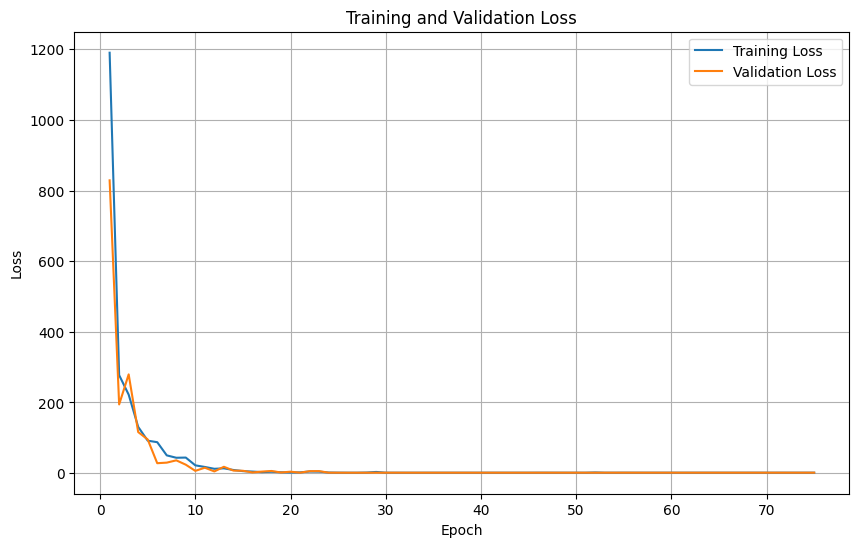

Test Loss: 2.4037
Test Accuracy: 50.32%


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from NeuralNet import FeedForwardNN  # Import the FeedForwardNN class
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the model
input_size = X_train.shape[1]  # Number of features
hidden_sizes = [32, 64, 128]  # Hidden layer sizes
model = FeedForwardNN(input_size=input_size, hidden_sizes=hidden_sizes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to log losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 75
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    # Log losses
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Testing phase
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")